# Downloading Datset

Update the gdown first so that it can download large-sized file

In [1]:
!pip install --upgrade --no-cache-dir gdown

Downloading the dataset

In [2]:
!gdown https://drive.google.com/uc?id=1nlC561JoAyFjMg9cuGyGf_9h77yRgydW

Downloading...
From: https://drive.google.com/uc?id=1nlC561JoAyFjMg9cuGyGf_9h77yRgydW
To: /content/traffic_sign.zip
100% 40.1M/40.1M [00:00<00:00, 69.3MB/s]


In [3]:
!unzip -q -o traffic_sign.zip

# Imports

In [4]:
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog

In [5]:
import torch
import numpy as np

torch.manual_seed(1337)
np.random.seed(1337)

# Dataset Loader

In [6]:
from PIL import Image
from torch.utils.data import Dataset

class TrafficSignImageDataset(Dataset):

    def __init__(self, path, transform=None):
        
        folders = os.listdir(path)
        folders = [x for x in folders if os.path.isdir(os.path.join(path, x))]
        
        self.transform=transform

        self.filenames = []
        self.labels = []
    
        for label, folder in enumerate(folders):
            folderpath = os.path.join(path, folder)
            
            files = os.listdir(folderpath)
            np.random.shuffle(files)
    
            for f in files:
                filename = os.path.join(folderpath, f)
                self.filenames.append(filename)
                self.labels.append(label)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename, label = self.filenames[i], self.labels[i]
        image = Image.open(filename).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 16
root = 'traffic_sign'

preprocessing = transforms.Compose([               
    transforms.Resize([40,40]),  
    transforms.RandomRotation(10),
    transforms.RandomCrop([32, 32]),   
    transforms.Grayscale(),
    transforms.ToTensor(),       
])

dataset = TrafficSignImageDataset(root, transform=preprocessing)
data_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True, num_workers=2)


In [8]:
for i, (x,y) in enumerate(data_loader):
    print(x.shape, y.shape)
    break

torch.Size([16, 1, 32, 32]) torch.Size([16])


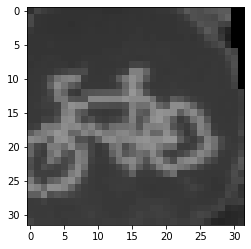

In [9]:
plt.imshow(x[0][0].numpy(), cmap='gray', vmin=0, vmax=1.)

# Model

In [10]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, feat_size, n_class):
        super(Net, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = torch.nn.Linear(feat_size, 128)
        self.layer2 = torch.nn.Linear(128, 64)
        self.layer3 = torch.nn.Linear(64, 16)
    
        self.classifier =  torch.nn.Linear(16, n_class)
        
    def forward(self, x):
        relu = self.relu
        x = x.reshape(-1,32*32)
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))
        x = relu(self.layer3(x))

        out = relu(self.classifier(x))

        return out

In [11]:
predictor = Net(32*32, 10)
pred = predictor(x)

In [12]:
print(torch.argmax(pred, dim=1))
print(y)

tensor([4, 8, 8, 4, 4, 4, 8, 4, 8, 8, 4, 8, 8, 4, 4, 8])
tensor([4, 3, 5, 0, 0, 4, 1, 0, 4, 3, 2, 9, 6, 2, 1, 7])


# Training

In [13]:
from torch.nn.functional import cross_entropy

def training(model, optimizer, data_loader, objective_function, device, max_iter=-1):
    model.train()

    for i, (x,y) in enumerate(data_loader):
        x = x.to(device)
        y = y.to(device)
        
        logits = model(x)
        
        loss = objective_function(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i==max_iter:
            break
    
    model.eval()

In [14]:

cpu = torch.device('cpu')
def count_acc(logits, label, device = cpu):
    pred = torch.argmax(logits, dim=1)
    return (pred == label).to(device).type(torch.FloatTensor).mean().item()

@torch.no_grad()
def evaluation(model, data_loader, objective_function, device, max_iter=-1):
    model.eval()

    loss_values = []
    accuracy_values = []

    for i, (x,y) in enumerate(data_loader):
        
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            
            logits = model(x)

            loss = objective_function(logits, y)
            acc = count_acc(logits, y, device)

        loss_values.append(loss.item())
        accuracy_values.append(acc)

        if i==max_iter:
            break

    loss = np.mean(loss_values)
    accuracy = np.mean(accuracy_values)

    return loss, accuracy

In [15]:
predictor = Net(32*32, 10)
pred = predictor(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor.to(device)

optimizer = torch.optim.Adam(predictor.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

In [16]:
epochs = 10
model_checkpoint = 'best_model.pth'

best_acc = 0
for e in range(epochs):
    training(predictor, optimizer, data_loader, cross_entropy, device, max_iter=-1)
    
    loss, acc = evaluation(predictor, data_loader, cross_entropy, device, max_iter=-1)
    scheduler.step()

    print('epoch %d loss=%f acc=%f'%(e, loss, acc))
    
    if acc>=best_acc:
        predictor.eval()
        torch.save(predictor.state_dict(), model_checkpoint)
        best_acc = acc

epoch 0 loss=2.134897 acc=0.244907
epoch 1 loss=1.886597 acc=0.366667
epoch 2 loss=1.768032 acc=0.456481
epoch 3 loss=1.673920 acc=0.519444
epoch 4 loss=1.651532 acc=0.496296
epoch 5 loss=1.581129 acc=0.544907
epoch 6 loss=1.539218 acc=0.540278
epoch 7 loss=1.480579 acc=0.577778
epoch 8 loss=1.428315 acc=0.586111
epoch 9 loss=1.416262 acc=0.594907
